In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ast
from skimage import io
from skimage.color import gray2rgb
from tqdm import tqdm
from collections import defaultdict
from scipy.interpolate import UnivariateSpline
from pymicro.view.vol_utils import compute_affine_transform
#https://pypi.org/project/affine6p/

In [2]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer, \
    create_full_volume, get_structure_colors
from utilities.sqlcontroller import SqlController
animal = 'MD589'
sqlController = SqlController(animal)
color_radius = 3
xy_ng_resolution_um = 5
color_radius = 3

CSV_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/foundation_brain_annotations'
csvfile = os.path.join(CSV_PATH, 'MD589_annotation.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations.head()
hand_annotations['vertices'] = hand_annotations['vertices'] \
    .apply(lambda x: x.replace(' ', ','))\
    .apply(lambda x: x.replace('\n',','))\
    .apply(lambda x: x.replace(',]',']'))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ',')).apply(lambda x: x.replace(',,', ','))

hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
df = hand_annotations[['name', 'section', 'side', 'vertices']].copy()
SC = df['name'] == "SC"
df = df[SC]
df = df.reset_index()
df = df.sort_values(by=['name', 'section'])
df.head()

Connecting dklab@192.168.1.12:3306


,index,name,section,side,vertices
161,2053,SC,128,S,"[[19215.04835969, 7565.78283213], [19075.22056..."
134,1633,SC,129,S,"[[19087.8481308, 8774.6015345], [18825.0396401..."
7,67,SC,130,S,"[[19948.38851097, 7820.87176667], [19861.60142..."
110,1290,SC,131,S,"[[19421.14715903, 7167.49789475], [19021.22326..."
169,2179,SC,132,S,"[[19326.57094395, 9053.63288676], [19240.50515..."


In [48]:
structures = ['DC', 'LC','SC', '5N', '7n']
# SC is the only singular structure
df = hand_annotations[['name', 'section', 'side', 'vertices']].copy()
df = df.loc[df['name'].isin(structures)
DC_L =  "DC" & df['side'] == "L"
DC_R = df['name'] == "LC" & df['side'] == "R"
LC_L = df['name'] == "DC" & df['side'] == "L"
LC_R = df['name'] == "LC" & df['side'] == "R"
SC = df['name'] == "SC"
n5_L = df['name'] == "5N" & df['side'] == "L"
n5_R = df['name'] == "5N" & df['side'] == "R"
n7_L = df['name'] == "7n" & df['side'] == "L"
n7_R = df['name'] == "7n" & df['side'] == "R"
df = df[DC_L | DC_R | LC_L | LC_R | SC | n5_L | n5_R | n7_L | n7_R]
df = df.reset_index()
df = df.sort_values(by=['name', 'section'])
df.head()

TypeError: Cannot perform 'rand_' with a dtyped [object] array and scalar of type [bool]

In [31]:
midpoints = {}
for structure in structures:    
    df2 = df.copy()
    df3 = df2[df2["name"] == structure]
    first_section = df3['section'].min()
    last_section = df3['section'].max()
    midpoints[structure] = int(((last_section - first_section) / 2) + first_section)

In [32]:
midpoints

{'DC': 229, 'LC': 224, 'SC': 219, '5N': 230, '7n': 233}

In [47]:
section_structure_vertices = defaultdict(dict)
for structure in tqdm(structures):
    contour_annotations, first_sec, last_sec = get_contours_from_annotations(animal, structure, df, densify=0)
    for section in sorted(contour_annotations):
        print(structure, first_sec, last_sec, section)
        section_structure_vertices[section][structure] = contour_annotations[section][structure][1]

100%|██████████| 5/5 [00:00<00:00, 53.05it/s]

SC 128 311 128
SC 128 311 129
SC 128 311 130
SC 128 311 131
SC 128 311 132
SC 128 311 133
SC 128 311 134
SC 128 311 135
SC 128 311 136
SC 128 311 137
SC 128 311 138
SC 128 311 139
SC 128 311 140
SC 128 311 141
SC 128 311 142
SC 128 311 143
SC 128 311 144
SC 128 311 145
SC 128 311 146
SC 128 311 147
SC 128 311 148
SC 128 311 149
SC 128 311 150
SC 128 311 151
SC 128 311 152
SC 128 311 153
SC 128 311 154
SC 128 311 155
SC 128 311 156
SC 128 311 157
SC 128 311 158
SC 128 311 159
SC 128 311 160
SC 128 311 161
SC 128 311 162
SC 128 311 163
SC 128 311 164
SC 128 311 165
SC 128 311 166
SC 128 311 167
SC 128 311 168
SC 128 311 169
SC 128 311 170
SC 128 311 171
SC 128 311 172
SC 128 311 173
SC 128 311 174
SC 128 311 175
SC 128 311 176
SC 128 311 177
SC 128 311 178
SC 128 311 179
SC 128 311 180
SC 128 311 181
SC 128 311 182
SC 128 311 183
SC 128 311 184
SC 128 311 185
SC 128 311 186
SC 128 311 187
SC 128 311 188
SC 128 311 189
SC 128 311 190
SC 128 311 191
SC 128 311 192
SC 128 311 193
SC 128 311

In [45]:
section_structure_vertices[230]['DC']

KeyError: 'DC'

In [34]:
point_array = {}
for structure, section in midpoints.items():
    try:
        point_array[structure] = section_structure_vertices[section][structure]
    except:
        print('no key for ', structure)
structures

no key for  DC
no key for  LC
no key for  5N
no key for  7n


['DC', 'LC', 'SC', '5N', '7n']

In [8]:
centers = {}
for structure in structures:
    cx = int(np.mean([x[0] for x in point_array[structure]]))
    cy = int(np.mean([x[1] for x in point_array[structure]]))
    centers[structure] = [cx,cy, midpoints[structure]]
    print(structure, cx, cy, midpoints[structure])

SC 23239 7698 219
AP 29256 13084 222
12N 29370 15352 225


In [9]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
thickness = 1
colors = {}
colors['DC'] = (0,0,0)
colors['LC'] = (255,0,0)
colors['SC'] = (255,0,255)
colors['5N'] = (0,255,255)
colors['7n'] = (100,10,255)

section_images = {}
points = {}
SCALE = 32
PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1'
OUTPUT = os.path.join(PATH, 'r_rmc_vta')
os.makedirs(OUTPUT, exist_ok=True)
thumbnail_dir = os.path.join(PATH, 'thumbnail')
files = sorted(os.listdir(thumbnail_dir))
for file_name in tqdm(files):
    filepath = os.path.join(thumbnail_dir, file_name)
    #img = io.imread(filepath)
    img = cv2.imread(filepath)
    section = int(file_name.split('.')[0])
    
    for structure in section_structure_vertices[section]:
        pts = section_structure_vertices[section][structure]
        points = np.array(pts, dtype=np.int32)
        
        point_arr = np.array(pts,dtype=np.float64)
        x = np.array([v[0] for v in point_arr])
        y = np.array([v[1] for v in point_arr])
        midx = int((sum(x) // len(point_arr)) // SCALE)
        midy = int((sum(y) // len(point_arr)) // SCALE)
        midx = int(min(x) // SCALE)
        midy = int(min(y) // SCALE)
        """
        old_len = points.shape[0]
        new_len = int(old_len * 1)
        indexes = np.arange(0, old_len)
        new_indexes = np.linspace(0,old_len-1, new_len)
        splx = UnivariateSpline(indexes,x,k=3,s=0)
        x_smooth = splx(new_indexes)
        sply = UnivariateSpline(indexes,y,k=3,s=0)
        y_smooth = sply(new_indexes)
        points = np.column_stack((x_smooth, y_smooth)).astype(np.int32)
        """
        points = points // SCALE
        if section == midpoints[structure]:
            points_diff = np.rint(points + np.random.rand() * 500)
            points_diff = points_diff.astype(np.int32)
            cv2.polylines(img, [points_diff], isClosed=True, color=(0,0,0), thickness=5)
            cx = centers[structure][0] // SCALE
            cy = centers[structure][1] // SCALE
            cv2.circle(img, (cx,cy), 10, (0,0,0), -1)
            
        cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=2)
        cv2.putText(img, structure, (midx,midy), font,
                    fontScale, colors[structure], thickness, cv2.LINE_AA)
        outpath = os.path.join(OUTPUT, file_name)
        cv2.imwrite(outpath, img)
            
    section_images[section] = img

100%|██████████| 448/448 [00:11<00:00, 38.88it/s] 


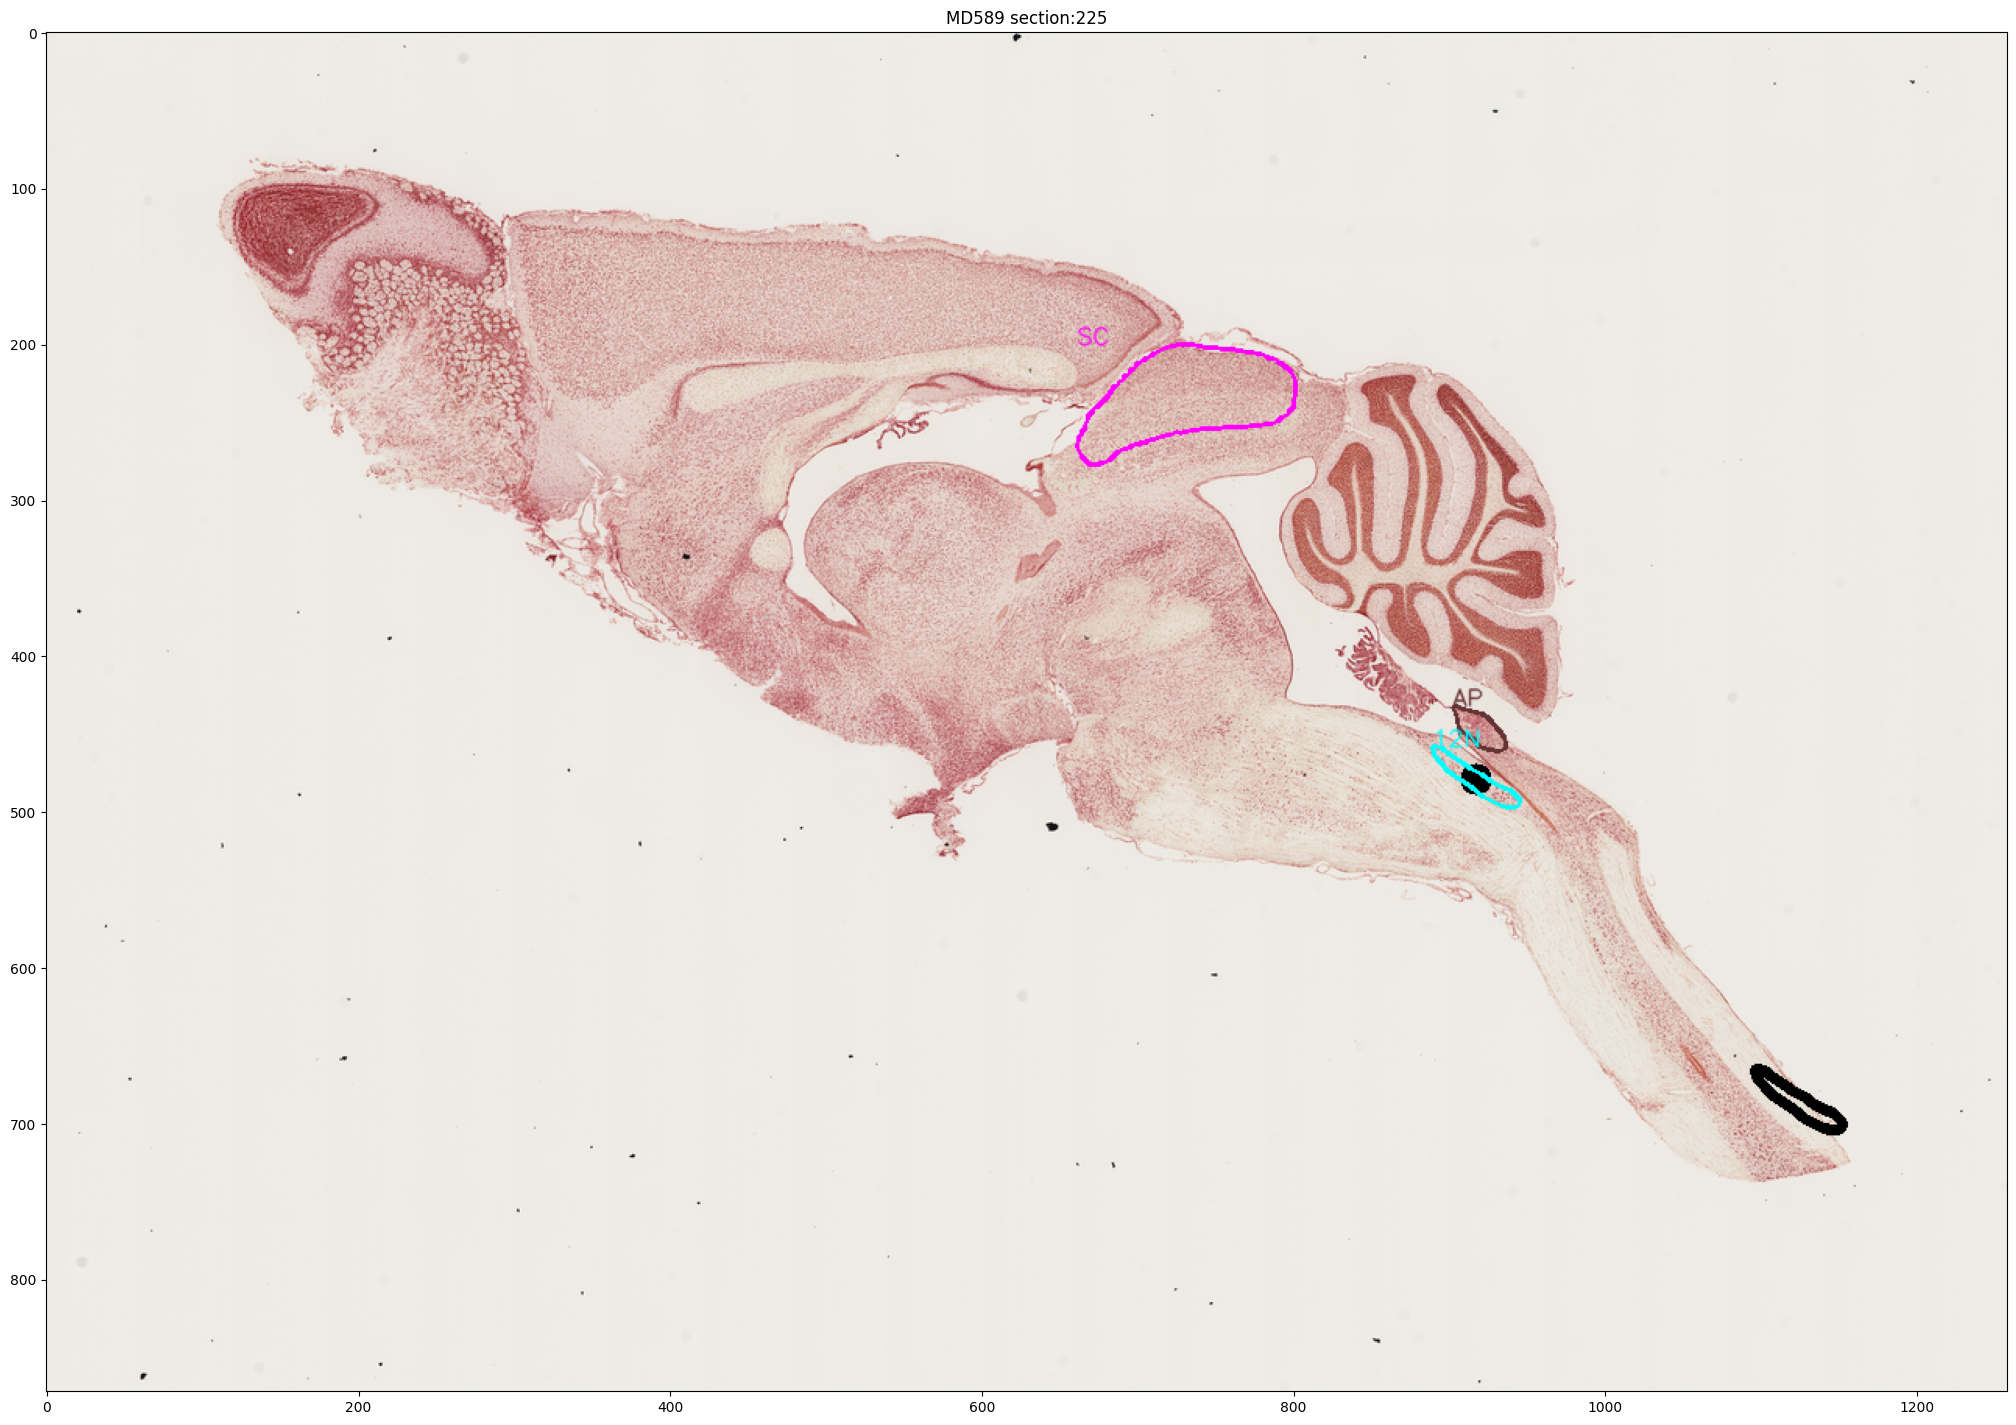

In [10]:
section = 225
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(section_images[section], cmap="cool")
plt.title('{} section:{}'.format(animal, section))
plt.show()

In [11]:
offsets = {}
for structure, coords in centers.items():
    cxoff = int(coords[0] + np.random.rand() * 500)
    cyoff = int(coords[1] + np.random.rand() * 500)
    print(structure, coords, cxoff, cyoff)
    offsets[structure] = [cxoff, cyoff, midpoints[structure]]

SC [23239, 7698, 219] 23574 7887
AP [29256, 13084, 222] 29579 13571
12N [29370, 15352, 225] 29755 15494


In [12]:
origin = np.array(list(centers.values()), dtype=np.float32)
fitted = np.array(list(offsets.values()), dtype=np.float32)
other_structure = (25000,15000,200)
print(origin.shape, fitted.shape)

(3, 3) (3, 3)


In [13]:
origin_centroid = np.mean(origin, axis=0)
fitted_centroid = np.mean(fitted, axis=0)

In [14]:
import affine6p
trans = affine6p.estimate(origin, fitted)
translated = trans.transform(other_structure)
print('translated',translated)
rotated = trans.rotate(other_structure)
print('rotated',rotated)
both = trans.rotate(translated)
print('both',both)

translated [25496.285041017516, 14349.286324179498]
rotated [24737.405127789883, 17432.622852296336]
both [25201.177107301068, 16983.750421320965]


In [15]:
from superpose3d import Superpose3D
results = Superpose3D(origin, fitted)

In [21]:
origin_centroid + np.dot(results[1], other_structure - fitted_centroid)

array([24668.5406575 , 14743.14850063,   198.27945988])

In [22]:
# compute the affine transform from the point set
translation, transformation = compute_affine_transform(origin, fitted)
invt = np.linalg.inv(transformation)
offset = -np.dot(invt, translation)
origin_centroid + np.dot(transformation, other_structure - fitted_centroid)

array([22056.36079645,   460.97086048,   218.90592289])

point 0 will move to (40039.9, 51153.6, 251.3) to be compared with (23239.0, 7698.0, 219.0)
point 1 will move to (26706.8, 2714.0, 212.6) to be compared with (29256.0, 13084.0, 222.0)
point 2 will move to (15118.3, -17733.6, 202.1) to be compared with (29370.0, 15352.0, 225.0)


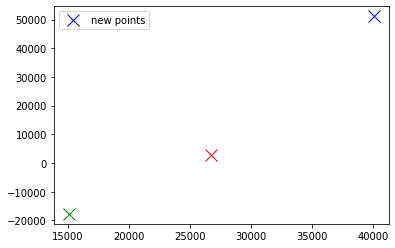

In [18]:
colors = 'brgmk'
new_points = np.empty_like(origin)
for i in range(len(origin)):
    new_points[i] = origin_centroid + np.dot(transformation, fitted[i] - fitted_centroid)
    print('point %d will move to (%3.1f, %3.1f, %3.1f) to be compared with (%3.1f, %3.1f, %3.1f)' % (
    i, new_points[i, 0], new_points[i, 1], new_points[i, 2], origin[i, 0], origin[i, 1], origin[i, 2]))
    plt.plot(new_points[i, 0], new_points[i, 1], 'x', color=colors[i], markersize=12,
             label='new points' if i == 0 else '')
plt.legend(numpoints=1)
plt.show()


In [19]:
new_points

array([[ 40039.875  ,  51153.63   ,    251.32437],
       [ 26706.79   ,   2714.0137 ,    212.55803],
       [ 15118.332  , -17733.648  ,    202.11758]], dtype=float32)